# [0] 미션 설명

다양한 Hybrid Approach에 대해 알고, 이를 직접 코드로 작성해 본다.

> **학습 목표**
> - 추천에서의 앙상블 방법인 Hybrid Approach에 대해 확인한다.
> - 여러 모델들을 구현하고 이를 앙상블하는 흐름을 배운다.
> - 하이브리드 접근법 중, 일부를 코드로 작성하여 본다.

RecSys 기초 대회 강의에서는 Book Crossing 데이터를 사용하여 모든 실습 및 미션, 대회를 진행합니다. [Kaggle Book-Crossing](https://www.kaggle.com/datasets/ruchi798/bookcrossing-dataset) 을 출처로 하며, 데이터는 재구성되어 제공되었습니다. 해당 데이터는 CC0: Public Domain 라이센스임을 밝힙니다.

그럼 본격적으로 **(미션-3) Hybrid Approach** 를 진행하여 보겠습니다.


In [102]:
# install packages
!pip install catboost -q
!pip install scikit-surprise -q

In [103]:
# import packages
import pandas as pd
import numpy as np
import warnings

import re
from pandas.api.types import CategoricalDtype
from scipy import sparse
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier, LGBMRanker
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

from surprise import Dataset, Reader, accuracy, SVD, KNNBasic, CoClustering
from surprise.dataset import DatasetAutoFolds

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

# [1] Hybrid Approach 이란?

추천 시스템은 사용자의 취향을 예측하여 가장 적절한 결과를 추천하기 위한 목적이 있습니다.
그러나 이 때, 단일 모델만으로 가장 적합한 결과를 만들어 내기 어렵습니다. 각 모델이 활용하는 feature, 잘 작동하는 상황 등이 모두 다르기 때문입니다.

하이브리드 접근법이란 이를 보완하기 위해 여러 모델을 결합하여, 결과를 도출하는 것을 의미합니다. 이를 통해 각 모델의 장점을 사용하여 다른 모델의 단점을 상쇄, 즉 상호 보완하여 성능을 끌어 올릴 수 있습니다.

대부분의 추천 시스템은 단일 모델만으로 추천을 진행한다기 보단, 하이브리드 접근법을 사용합니다.
하이브리드 접근법은 4강, 5강에서 언급한 바와 같이, Collaborative Filtering, Content Based recommend 등 여러 모델을 결합하는 것을 의미합니다.



하이브리드 접근법은 크게 3가지 대분류와 7가지 종류로 확인할 수 있습니다.

1. Monolithic hybrid designs
> 다양한 feature를 활용하는 단일 모델
  - Feature combination
  - Feature Augmentation
2. Parallelized hybrid design
> 여러 추천 시스템 간의 병렬적인 사용
  - Weighted
  - Switching
  - Mixed
3. Pipelined hybrid designs
> 후속 입력을 위해 일부 입력을 사전 처리하는 방식
  - Cascade
  - Meta‐level


# [2] 하이브리드 접근법의 종류
다양한 방식으로 여러 추천 시스템 기법을 결합하여 사용자의 취향을 효과적으로 예측할 수 있습니다.

## (1) Monolithic hybrid designs

### Feature combine

> 협업 필터링 추천 시스템의 결과를 콘텐츠 기반 추천 시스템 속성의 일부로 사용하는 방식
<div>
<img src="https://miro.medium.com/max/1400/1*K4ZRADAka8DUM3xh8H76DQ.jpeg"
width="700"/>
</div>

[출처](https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8)


- 예를 들어, 서로 다른  소스에서 파생된 feature가 함께 결합되어 단일 추천 알고리즘에 제공됩니다.
- 사용한 콘텐츠 기반 추천 시스템에 적용하기 전에, 다양한 sources들을 단일된 표현으로 통합합니다.
- 아이템의 내재적인 정보를 이용함으로서 협업 필터링이 가진 단점을 상쇄합니다.







### Feature argument
> 한 추천시스템의 결과를 다음 추천시스템의 입력값으로 사용하는 방식
<div>
<img src="https://miro.medium.com/max/1400/1*1O_Ve4JyETRCybwT6-1ErA.jpeg"
width="700"/>
</div>

[출처](https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8)

- staking 방식과 비슷한 방식으로 이루어 집니다.
- 1단계의 추천시스템이 features를 만들어서 2단계(Main)의 추천시스템의 입력 값으로 사용합니다.

- 예시
  - CB → CF
  1. ratings matrix에서 결측치를 콘텐츠 기반 추천 시스템으로 채웁니다.
  2. 새롭게 채워진 ratings들을 pseudo-ratings라고 하며, 이렇게 채워진 dense ratings 행렬을 사용해 ratings을 예측합니다.


## (2) Parallelized hybrid design

### Weighted
> Soft Ensemble 또는 Hard Vote와 같은 방법으로 여러 모델의 추천 결과를 하나로 합쳐 최종 추천 아이템을 정하는 방식

<div>
<img src="https://miro.medium.com/max/1400/1*N9TO6n2tlo1sN8GhsB-tqw.jpeg"
width="700"/>
</div>

[출처](https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8)

- 가장 보편적인 앙상블 방식
- 각 모델의 추천 결과를 구하고, 가중치, 투표 등의 방법을 통해 최종 결과 산출


### Switching
> 플랫폼 내 사용자 또는 서비스 상태 등 특정 상황을 고려하여 여러 추천 알고리즘의 추천 결과를 선택적으로 보여주는 방식
<div>
<img src="https://miro.medium.com/max/1400/1*oyZqArrmwxb5n-sshMzq-w.jpeg" width="700"/>
</div>

[출처](https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8)


- 사용하는 추천시스템 모델을 n개 만들고 랜덤 혹은 일정 기준에 맞춰 모델을 변경하여 추천


### Mixed
> 서로 다른 추천에서 나오는 결과물을 섞어서 제공하는 방식

<div>
<img src="https://miro.medium.com/max/1400/1*jcpCf-mfB4AI7JL7x6WmqA.jpeg"
width="700"/>
</div>

[출처](https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8)

- 사용자 수준에서 다양한 추천 시스템의 결과를 결합합니다.
- 여러 추천 시스템의 결과를 활용하고, 이 때 알고리즘의 추천 결과를 모두 보여주는 방식



## (3) Pipelined hybrid designs


### Cascade
> 추천시스템이 다른 추천시스템에 의해 정제된 아이템을 추천하는 방식
<div>
<img src="https://miro.medium.com/max/1400/1*e2oXjzfycXx8WuUMiFmUHA.jpeg"
width="700"/>
</div>

[출처](https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8)


- cascade 방식은 boosting에 가까운 형식입니다.
- 2차 모델의 추천은 1차 모델에 의해 제한됩니다.
- 예를 들어, 1차 모델(KB)를 통해 항목을 제거합니다.
- (rescore) 2차 모델이 점수를 부여합니다.

### Meta-level
> 하나의 추천 기법이 적용되어 일종의 모델을 생성하고, 이는 다음 기법에서 사용되는 입력입니다.

이 중, 
Paralled Hybrid Approach 인 Mixed, Weighted 방법론과 Monolitic Hybrid Approach의 한 종류인 Feature combine에 대해 알아보겠습니다.

# [3] 데이터 불러오기

먼저, 미션용 데이터를 불러 옵니다.
wget 형식으로 불러 오며, 다음과 같은 id를 가졌습니다.

- book : 13SoqiN_xLWvQPDXnNdzvzwm1KSRJpfrL
- rating : 1YwubS7oWbAS2-wG8-qEDD4RqI_KwX8Fy
- user : 17Zbpx_Yn0ggLFVeijUalcnOUt5mCHeEH

In [104]:
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=17Zbpx_Yn0ggLFVeijUalcnOUt5mCHeEH' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=17Zbpx_Yn0ggLFVeijUalcnOUt5mCHeEH" -O users.csv && rm -rf ~/cookies.txt
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JIxWPgC8JJkuZaWjk5FJBBKuqSX87HGE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1JIxWPgC8JJkuZaWjk5FJBBKuqSX87HGE" -O books.csv && rm -rf ~/cookies.txt
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1B-8lw3a1KPJdhFAMXP58a7taJjpDvfw6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1B-8lw3a1KPJdhFAMXP58a7taJjpDvfw6" -O ratings.csv && rm -rf ~/cookies.txt

In [105]:
books = pd.read_csv('./data/books.csv').rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
users = pd.read_csv('./data/users.csv').rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
ratings = pd.read_csv('./data/train_ratings.csv').rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [106]:
books.shape, users.shape, ratings.shape

((149570, 17), (68092, 3), (306795, 3))

book에 대한 전처리를 진행합니다.
먼저, 아이디에 대해 처리를 해줍니다.

In [107]:
books['isbn'] = books['img_url'].apply(lambda x: x.split('P/')[1][:10])

각각의 데이터 프레임을 확인합니다.

In [108]:
print("<<< Dataframe users Example >>>")
print('users shape:\n', users.shape)
print('\ncol nunique:\n', users.nunique(),end='\n\n')
display(users.head(3))

<<< Dataframe users Example >>>
users shape:
 (68092, 3)

col nunique:
 user_id     68092
location    18368
age            91
dtype: int64



,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN


In [109]:
print("<<< Dataframe books Example >>>")
print('books shape:\n', books.shape)
print('\ncol nunique:\n', books.nunique(),end='\n\n')
display(books.head(3))

<<< Dataframe books Example >>>
books shape:
 (149570, 17)

col nunique:
 Unnamed0               149570
isbn                   149570
book_title             135436
year_of_publication        95
publisher               11571
img_url                149570
language                   26
summary                 79872
img_path               149570
category_high             749
book_author             61828
book_author_over10       2105
category                 4231
new_language               41
remove_country_code    148470
isfiction                   2
isenglish                   2
dtype: int64



,Unnamed0,isbn,book_title,year_of_publication,publisher,img_url,language,summary,img_path,category_high,book_author,book_author_over10,category,new_language,remove_country_code,isfiction,isenglish
0,0,0002005018,Clara Callan,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,en,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,actresses,Richard Bruce Wright,others,['actresses'],en,002005018,0,1
1,1,0060973129,Decision in Normandy,1991.0,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,en,"Here, for the first time in paperback, is an o...",images/0060973129.01.THUMBZZZ.jpg,others,Carlo D'Este,others,['1940-1949'],en,060973129,0,1
2,2,0374157065,Flu: The Story of the Great Influenza Pandemic...,1999.0,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,en,"Describes the great flu epidemic of 1918, an o...",images/0374157065.01.THUMBZZZ.jpg,medical,Gina Bari Kolata,others,['medical'],en,374157065,0,1


In [110]:
print("<<< Dataframe ratings >>>")
print('ratings shape:\n', ratings.shape)
print('\ncol nunique:\n', ratings.nunique(),end='\n\n')
display(ratings.head(3))

<<< Dataframe ratings >>>
ratings shape:
 (306795, 3)

col nunique:
 user_id     59803
isbn       129777
rating         10
dtype: int64



,user_id,isbn,rating
0,8,0002005018,4
1,67544,0002005018,7
2,123629,0002005018,8


# [4] 데이터 가공하기

## Preprocessing

- 고유 번호인 user_id와 isbn 대신 사용하기 편하게 인덱싱 처리를 해줍니다.


In [111]:
user2idx = {v:k for k,v in enumerate(ratings['user_id'].unique())}
book2idx = {v:k for k,v in enumerate(ratings['isbn'].unique())}

ratings['iid'] = ratings['isbn'].map(book2idx)
ratings['uid'] = ratings['user_id'].map(user2idx)

In [112]:
ratings.head(3)

,user_id,isbn,rating,iid,uid
0,8,0002005018,4,0,0
1,67544,0002005018,7,0,1
2,123629,0002005018,8,0,2


이 때, 각 데이터 프레임에 존재하는 결측치를 -1로 채워 줍니다.

In [113]:
print('books 데이터 프레임의 결측치')
books.isnull().sum()

books 데이터 프레임의 결측치


Unnamed0                   0
isbn                       0
book_title                 0
year_of_publication        0
publisher                  0
img_url                    0
language               67227
summary                67227
img_path                   0
category_high          62565
book_author                0
book_author_over10         0
category               69461
new_language            1100
remove_country_code     1100
isfiction                  0
isenglish                  0
dtype: int64

In [114]:
print('users 데이터 프레임의 결측치')
users.isnull().sum()

users 데이터 프레임의 결측치


user_id         0
location        0
age         27833
dtype: int64

In [115]:
print('ratings 데이터 프레임의 결측치')
ratings.isnull().sum()

ratings 데이터 프레임의 결측치


user_id    0
isbn       0
rating     0
iid        0
uid        0
dtype: int64

In [116]:
books.fillna(-1,inplace=True)
users.fillna(-1,inplace=True)
ratings.fillna(-1,inplace=True)

user-item에 대한 interaction matrix를 만들어 줍니다.
메모리 관리를 위해 pivot 대신 coo matrix로 만듭니다.

In [117]:
from pandas.api.types import CategoricalDtype
from scipy import sparse

size_uid = ratings["uid"].unique()
size_iid = ratings["iid"].unique()

ui_shape = (len(size_uid), len(size_iid))

user_cat = CategoricalDtype(categories=sorted(size_uid), ordered=True)
book_cat = CategoricalDtype(categories=sorted(size_iid), ordered=True)

user_index = ratings["uid"].astype(user_cat).cat.codes
book_index = ratings["iid"].astype(book_cat).cat.codes

interactions = sparse.coo_matrix((ratings["rating"], (user_index,book_index)), shape=ui_shape)

In [118]:
interactions

<59803x129777 sparse matrix of type '<class 'numpy.int64'>'
	with 306795 stored elements in COOrdinate format>

spare한 정도를 확인하여 봅시다.

In [119]:
def check_sparsity(interactions:sparse.coo_matrix)->int:
  matrix_size = interactions.shape[0]*interactions.shape[1] # Number of possible interactions in the matrix
  num_purchases = len(interactions.nonzero()[0]) # Number of items interacted with
  sparsity = 100*(1 - (num_purchases/matrix_size))
  return round(sparsity,4)

In [120]:
print(f"matrix sparsity : {check_sparsity(interactions)}%")

matrix sparsity : 99.996%


### Train/Test Split (Interaction)

Train, Test를 분할합니다.

- 행렬에서 0이 아닌 즉, 평가 기록이 있는 데이터를 랜덤하게 Train, Test 로 나눠 줍니다.
- data를 shuffle한 후, 유저를 기준으로 나눕니다.

In [121]:
def shuffle_data(interactions:sparse.coo_matrix, random_state:int=42)->tuple:
    random_state = np.random.RandomState(seed=random_state)

    interactions = interactions.tocoo()

    uids, iids, data = (interactions.row, interactions.col, interactions.data)

    shuffle_indices = np.arange(len(uids))
    random_state.shuffle(shuffle_indices)

    uids = uids[shuffle_indices]
    iids = iids[shuffle_indices]
    data = data[shuffle_indices]

    return uids, iids, data

In [122]:
def cutoff_by_user(uids:list, test_percentage:float=0.2):
    cutoff = int((1.0 - test_percentage) * len(uids))
    train_idx = slice(None, cutoff)
    test_idx = slice(cutoff, None)
    return train_idx, test_idx

추가로 위치에 맞게 평가 기록을 추가하는 코드를 작성합니다.

In [123]:
def random_train_test_split(interactions, test_percentage=0.2, valid=None, random_state=42):
    uids, iids, data = shuffle_data(interactions, random_state)
    train_idx, test_idx = cutoff_by_user(uids, test_percentage)
    shape = interactions.shape

    train = sparse.coo_matrix(
        (data[train_idx], (uids[train_idx], iids[train_idx])),
        shape=shape,
        dtype=interactions.dtype,
    )
    test = sparse.coo_matrix(
        (data[test_idx], (uids[test_idx], iids[test_idx])),
        shape=shape,
        dtype=interactions.dtype,
    )
    return train, test

In [124]:
train, test = random_train_test_split(interactions,test_percentage=0.2,random_state=42)

라이브러리에서 원활한 사용을 위해 csr_matrix로 변환하여 줍니다.

In [125]:
train = train.tocsr()
test = test.tocsr()

In [126]:
train, test

(<59803x129777 sparse matrix of type '<class 'numpy.int64'>'
 	with 245436 stored elements in Compressed Sparse Row format>,
 <59803x129777 sparse matrix of type '<class 'numpy.int64'>'
 	with 61359 stored elements in Compressed Sparse Row format>)

### Train/Test Split (DataFrame)

GBDT 모델도 사용하기 위해 데이터프레임도 만들겠습니다.
random_train_test_split에서 사용하였던 데이터와 동일하게 사용합니다.

In [127]:
uids, iids, data = shuffle_data(interactions)
train_idx, test_idx = cutoff_by_user(uids)

train_df = pd.DataFrame({'uid':uids[train_idx], 'iid':iids[train_idx], 'ratings':data[train_idx]})
test_df = pd.DataFrame({'uid':uids[test_idx], 'iid':iids[test_idx], 'ratings':data[test_idx]})

앞서 제작한 매트릭스의 stored elements 갯수와 shape[0] 같음을 확인할 수 있습니다.

In [128]:
train_df.shape, test_df.shape

((245436, 3), (61359, 3))

In [129]:
train_df.head()

,uid,iid,ratings
0,15485,1638,7
1,10191,13639,6
2,16627,125648,8
3,3459,103855,7
4,2266,795,9


## Feature Engineering

contents based recommender 모델을 위한 여러 feature를 생성합니다.

### User
user에서부터 파생된 feature로 location, age를 사용하여, 모델 생성 예정으로 이를 처리합니다.

In [130]:
users_location = pd.concat(
    [users.drop('location', axis=1), 
     (users['location'].str.split(',', expand=True)
     .assign(location_country = lambda x : np.where(x[2]=='', x[3], x[2]),
            location_state = lambda x : x[1],
            location_city = lambda x : x[0],
            ) 
      )[['location_country', 'location_state', 'location_city']]
     ], axis=1)

city_tab = pd.DataFrame([['iowa city','iowa','usa'],
['somerset', 'somerset','england'],
['milford','massachusetts','usa'],
['rockvale','tennessee','usa'],
['bronx','newyork','usa'],
['tustin','california','usa'],
['choctaw','choctaw','usa'],
['richmond hill','richmond hill','canada'],
['kuala lumpur','kuala lumpur','malaysia']])
city_tab.columns = ['city','state','country']

for _,row in city_tab.iterrows():
    location_idx = users_location['location_city'] == row.city
    users_location.loc[location_idx,'location_city'] = row.city
    users_location.loc[location_idx,'location_state'] = row.state
    users_location.loc[location_idx,'location_country'] = row.country

users_location.fillna('unknown',inplace=True)
users_location['location_country'] = users_location['location_country'].str.replace('n/a','unknown')
users_location['location_city'] = users_location['location_city'].str.replace('n/a','unknown')
users_location['location_state'] = users_location['location_state'].str.replace('n/a','unknown')

sklearn의 LabelEncoder을 통해 라벨 인코딩하여 사용하였습니다.

In [131]:
users_df = users_location.copy()
users_df['uid'] = users_df['user_id'].map(user2idx)

아래와 같이 신규 user가 존재함을 확인할 수도 있습니다.

In [132]:
users_df.isnull().sum()

user_id                0
age                    0
location_country       0
location_state         0
location_city          0
uid                 8289
dtype: int64

In [133]:
u_label = ['location_country', 'location_state', 'location_city']
u_encoder = dict()
for l in u_label:
    u_encoder[l] = LabelEncoder()
    u_encoder[l].fit(users_df[l])
    users_df[l] = u_encoder[l].transform(users_df[l])

연속형 변수인 age에 대해 연령대별 카테고리화해 줍니다.

In [134]:
users_df['age'] = users_df['age'].map(lambda x:x//10 if type(x)!=str else -1)

In [135]:
users_df.head()

,user_id,age,location_country,location_state,location_city,uid
0,8,-1.0,55,1050,10871,0.0
1,11400,4.0,55,1050,8071,2334.0
2,11676,-1.0,315,1428,11127,13.0
3,67544,3.0,55,1050,10928,1.0
4,85526,3.0,55,225,11310,4789.0


### Item
마찬가지로 item Feature 도 라벨인코딩해 줍니다.

먼저, isbn을 iid로 바꾸어 줍니다.

In [136]:
books_df = books.copy()
books_df['iid'] = books_df['isbn'].map(book2idx)

이어, 정규 표현식을 통해 카테고리를 보다 정제하여 주겠습니다.

In [137]:
books_df['category'] = books_df['category'].apply(lambda x: re.sub('[\W_]+',' ',str(x)).strip())

결측치 처리 시, -1로 대체하였기 때문에 label encoding의 작동을 원활히 하기 위해 데이터의 type을 일치시켜 

In [138]:
books_df['category'] = books_df['category'].astype(str)
books_df['language'] = books_df['language'].astype(str)

item에 대한 정보는 제목, 작가명, 출판사 등 다양한 정보가 있지만 간결성을 위해 year_of_publication	, language, category를 제외하고 drop합니다.

In [139]:
i_label = ['category', 'language']
i_encoder = dict()
for l in i_label:
    i_encoder[l] = LabelEncoder()
    i_encoder[l].fit(books_df[l])
    books_df[l] = i_encoder[l].transform(books_df[l])

context aware recommendation을 위해, 각각의 데이터 프레임을 iid, uid를 기준으로 merge해 줍니다.

In [140]:
train_context = train_df.merge(users_df, on='uid', how='left').merge(books_df, on='iid', how='left')
test_context = test_df.merge(users_df, on='uid', how='left').merge(books_df, on='iid', how='left')

In [141]:
train_context.isna().sum()

uid                    0
iid                    0
ratings                0
user_id                0
age                    0
location_country       0
location_state         0
location_city          0
Unnamed0               0
isbn                   0
book_title             0
year_of_publication    0
publisher              0
img_url                0
language               0
summary                0
img_path               0
category_high          0
book_author            0
book_author_over10     0
category               0
new_language           0
remove_country_code    0
isfiction              0
isenglish              0
dtype: int64

train/test set을 분할합니다.
추가적으로 다른 모델과 결과 공유할 때 같은 uid, iid 임을 확인하기 위해 rating_train/test 를 저장합니다.

In [142]:
X_train = train_context.drop(['user_id', 'isbn', 'iid','uid', 'ratings'], axis=1)
y_train = train_context['ratings']
rating_train = train_context[['uid','iid','ratings']] 

X_test = test_context.drop(['user_id', 'isbn', 'iid','uid', 'ratings'], axis=1)
y_test = test_context['ratings']
rating_test = test_context[['uid','iid','ratings']] 

불필요한 feature를 제거하여 줍니다.

In [143]:
drop_lst = ['book_title','book_author','publisher','img_url','img_path','summary']

X_train.drop(drop_lst,axis=1,inplace=True)
X_test.drop(drop_lst,axis=1,inplace=True)

In [144]:
# RAM 관리를 위해 사용하지 않는 데이터 프레임을 삭제해 줍니다.
# magic command 를 사용하여 현행 정의해놓은 변수 목록을 확인한 후, 삭제합니다.
#  %whos

In [145]:
# del ratings, users, books, books_df, users_df, users_location, city_tab

우리는 대회에서 사용하는 평가 지표 RMSE를 동일하게 사용하여, 모델을 평가합니다. 이를 위해 rmse를 측정하는 함수를 제작합니다.

In [146]:
def modify_range(rating):
  if rating < 0:
    return 0
  elif rating > 10:
    return 10
  else:
    return rating

In [147]:
def rmse(real, predict):
  pred = list(map(modify_range, predict))  
  pred = np.array(pred)
  return np.sqrt(np.mean((real-pred) ** 2))

In [148]:
def matrix_rmse(real_mat, predict_mat, test_ind=test_idx):
  cost = 0

  for i, ind in enumerate(test_ind):
    pred = predict_mat[ind]
    real = real_mat[ind]
    cost += pow(real - modify_range(pred), 2)
  return np.sqrt(cost/ len(test_ind)) 

# [5] 단일 모델 확보

하이브리드 접근법 파트에서 바로 사용할 수 있도록 모델을 미리 만들어 놓겠습니다.

지금까지 3,4, 5강에서 배웠던 방법론들을 이용하여 보겠습니다.

## SVD
5강에서 배웠던 surprise 라이브러리를 사용하여 모델을 만들어 줍니다.

In [149]:
reader = Reader(rating_scale=(1, 10))
train_data = Dataset.load_from_df(train_df[['uid', 'iid', 'ratings']], reader)
test_data = Dataset.load_from_df(test_df[['uid', 'iid', 'ratings']], reader)

In [150]:
fold = DatasetAutoFolds(df = train_df[['uid', 'iid', 'ratings']], reader = reader)
trainset = fold.build_full_trainset()

모든 미지수를 추정하기 위해 다음과 같은 정규화 제곱 오차를 최소화합니다.

$$
\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u
$$

최소화는 매우 간단한 확률적 경사 하강법으로 수행됩니다.
$$e_{ui} = r_{ui} - \hat{r}_{ui}$$ 
일 때,
$$
\begin{split}b_u &\leftarrow b_u &+ \gamma (e_{ui} - \lambda b_u)\\
b_i &\leftarrow b_i &+ \gamma (e_{ui} - \lambda b_i)\\
p_u &\leftarrow p_u &+ \gamma (e_{ui} \cdot q_i - \lambda p_u)\\
q_i &\leftarrow q_i &+ \gamma (e_{ui} \cdot p_u - \lambda q_i)\end{split}
$$
이 단계는 trainset의 모든 rating에 대해 n_epochs만큼 반복 수행됩니다.


In [151]:
params = {'n_factors':100,
          'n_epochs':20,
          'lr_all':0.005,
          'reg_all':0.02}

svd = SVD(**params,random_state=42)
svd.fit(trainset)

예측을 위해 test 메소드에서 사용할 (u,i,r) 형식의 리스트를 생성합니다.

In [152]:
uir_tuple = list(zip(test_df['uid'], test_df['iid'],test_df['ratings']))

In [153]:
svd_test = svd.test(uir_tuple)

In [154]:
svd_pred = list(map(lambda x:round(x.est), svd_test))
pd.Series(svd_pred).value_counts()

7     29617
8     15569
6      7905
9      4502
5      1973
4       716
3       639
10      398
2        37
1         3
dtype: int64

모델의 성능을 파악하기 위한 score dictionary를 생성하고, SVD 모델의 RMSE를 기록합니다.
파라미터 또한 기록하여 줍니다.

In [155]:
param = {}
param['svd'] = params

In [156]:
score = {}
score['svd'] = rmse(y_test, svd_pred)

In [157]:
pred = {}
pred['svd'] = svd_pred

In [158]:
rmse_v = score['svd']
print(f"RMSE of svd : {round(rmse_v,4)}")

RMSE of svd : 2.2152


## Co-clustering
사용자와 아이템에 각각 $C_u$,$C_i$,$C_ui$ 클러스터가 부여되고, 이에 대한 평균 평점에서부터 평점을 계산합니다.


$$
\hat{r}_{ui} = \overline{C_{ui}} + (\mu_u - \overline{C_u}) + (\mu_i- \overline{C_i})
$$

In [159]:
params = {'n_cltr_u':10, 'n_cltr_i':10, 'n_epochs':20}
param['coclu'] = params

In [160]:
coclu = CoClustering(**params, random_state=42, verbose=True)
coclu.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [161]:
coclu_test = coclu.test(uir_tuple)

In [162]:
coclu_pred = list(map(lambda x:round(x.est), coclu_test))
pd.Series(coclu_pred).value_counts()

7     32177
8      8233
9      5971
6      4491
10     4174
5      2650
4      1460
3       996
1       607
2       600
dtype: int64

In [163]:
pred['coclu'] = coclu_pred

In [164]:
score['coclu'] = rmse(y_test, coclu_pred)

In [165]:
rmse_v = score['coclu']
print(f"RMSE of coclustering : {round(rmse_v,4)}")

RMSE of coclustering : 2.5071


## LGBM

#### LGBM Classifier

In [166]:
params = {'objective':'rmse',
  'boosting_type':'gbdt',
  'lambda': 0.1,
 'learning_rate': 0.03,
 'max_depth': 34,
 'num_leaves': 34,
 'n_epochs': 18}

In [167]:
lgbm_cl = LGBMClassifier(**params ,random_state=42)
lgbm_cl.fit(X_train.select_dtypes(exclude='object'), y_train)
lgbm_pred_cl = lgbm_cl.predict(X_test.select_dtypes(exclude='object'))
rmse(y_test,lgbm_pred_cl)

2.5746692200347607

In [168]:
pd.Series(lgbm_pred_cl).value_counts()

8     56098
10     2835
9      1011
7       565
4       357
2       267
3       120
1       106
dtype: int64

In [169]:
param['lgbm'] = params

In [170]:
score['lgbm_cl'] = rmse(y_test,lgbm_pred_cl)

In [171]:
pred['lgbm_cl'] = lgbm_pred_cl

In [172]:
rmse_v = score['lgbm_cl']
print(f"RMSE of lgbm_classifier : {round(rmse_v,4)}")

RMSE of lgbm_classifier : 2.5747


#### LGBM Regressor

In [173]:
lgbm_r = LGBMRegressor(**params ,random_state=42)
lgbm_r.fit(X_train.select_dtypes(exclude='object'), y_train)
lgbm_pred_r = lgbm_r.predict(X_test.select_dtypes(exclude='object'))

[LightGBM] [Warning] Unknown parameter: n_epochs
[LightGBM] [Warning] lambda_l2 is set with lambda=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [174]:
score['lgbm_r'] = rmse(y_test,lgbm_pred_r)

In [175]:
pred['lgbm_r'] = lgbm_pred_r

<AxesSubplot: ylabel='Density'>

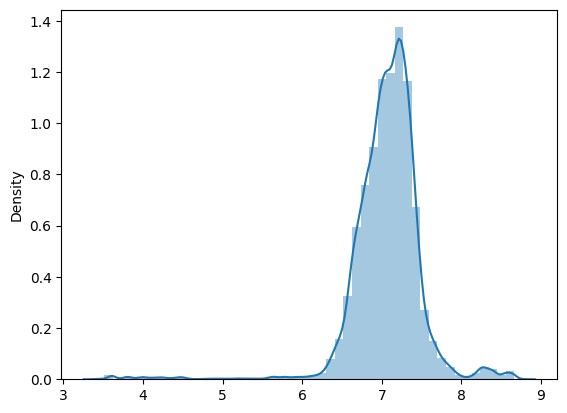

In [176]:
sns.distplot(pd.Series(lgbm_pred_r))

In [177]:
pd.Series(lgbm_pred_r).map(round).value_counts()

7    54349
8     4202
6     1932
4      431
9      301
5      133
3       11
dtype: int64

In [178]:
rmse_v = score['lgbm_r']
print(f"RMSE of lgbm_Regressor : {round(rmse_v,4)}")

RMSE of lgbm_Regressor : 2.3567


## Catboost

#### Catboost Classifier

In [179]:
params = {}
params['iterations'] = 100
params['learning_rate']=0.1
params['depth']=8

In [180]:
param['catboost'] = params

In [181]:
catboost_cl = CatBoostClassifier(**params, verbose=True, random_state=42)
catboost_cl.fit(X_train.select_dtypes(exclude='object'), y_train, early_stopping_rounds=100)
catboost_pred_cl = catboost_cl.predict(X_test.select_dtypes(exclude='object'))

0:	learn: 2.2549030	total: 262ms	remaining: 26s
1:	learn: 2.2184344	total: 526ms	remaining: 25.8s
2:	learn: 2.1896707	total: 746ms	remaining: 24.1s
3:	learn: 2.1658930	total: 1.09s	remaining: 26.2s
4:	learn: 2.1467779	total: 1.36s	remaining: 25.9s
5:	learn: 2.1305810	total: 1.72s	remaining: 26.9s
6:	learn: 2.1174950	total: 2.04s	remaining: 27.1s
7:	learn: 2.1049484	total: 2.35s	remaining: 27s
8:	learn: 2.0954610	total: 2.7s	remaining: 27.3s
9:	learn: 2.0875042	total: 3.05s	remaining: 27.5s
10:	learn: 2.0816459	total: 3.4s	remaining: 27.5s
11:	learn: 2.0755167	total: 3.73s	remaining: 27.4s
12:	learn: 2.0709916	total: 4.08s	remaining: 27.3s
13:	learn: 2.0671068	total: 4.38s	remaining: 26.9s
14:	learn: 2.0629118	total: 4.66s	remaining: 26.4s
15:	learn: 2.0591875	total: 4.93s	remaining: 25.9s
16:	learn: 2.0559524	total: 5.25s	remaining: 25.6s
17:	learn: 2.0538551	total: 5.51s	remaining: 25.1s
18:	learn: 2.0513250	total: 5.74s	remaining: 24.5s
19:	learn: 2.0494375	total: 6.01s	remaining: 24

In [182]:
score['catboost_cl'] = rmse(y_test,catboost_pred_cl.squeeze(1))

In [183]:
pred['catboost_cl'] = catboost_pred_cl.squeeze(1)

In [184]:
rmse_v = score['catboost_cl']
print(f"RMSE of Catboost Classifier : {round(rmse_v,4)}")

RMSE of Catboost Classifier : 2.6069


#### Catboost Regressor

In [185]:
catboost_r = CatBoostRegressor(**params, verbose=True, random_state=42)
catboost_r.fit(X_train.select_dtypes(exclude='object'), y_train, early_stopping_rounds=100)
catboost_pred_r = catboost_r.predict(X_test.select_dtypes(exclude='object'))

0:	learn: 2.4270181	total: 18.1ms	remaining: 1.79s
1:	learn: 2.4212968	total: 33.7ms	remaining: 1.65s
2:	learn: 2.4163044	total: 49ms	remaining: 1.58s
3:	learn: 2.4125796	total: 65ms	remaining: 1.56s
4:	learn: 2.4094756	total: 78.8ms	remaining: 1.5s
5:	learn: 2.4062509	total: 93.3ms	remaining: 1.46s
6:	learn: 2.4034655	total: 107ms	remaining: 1.43s
7:	learn: 2.4012903	total: 121ms	remaining: 1.39s
8:	learn: 2.3995111	total: 135ms	remaining: 1.37s
9:	learn: 2.3979077	total: 150ms	remaining: 1.35s
10:	learn: 2.3957896	total: 165ms	remaining: 1.33s
11:	learn: 2.3941560	total: 179ms	remaining: 1.31s
12:	learn: 2.3920128	total: 193ms	remaining: 1.29s
13:	learn: 2.3909687	total: 207ms	remaining: 1.27s
14:	learn: 2.3899611	total: 224ms	remaining: 1.27s
15:	learn: 2.3888538	total: 243ms	remaining: 1.27s
16:	learn: 2.3872612	total: 266ms	remaining: 1.3s
17:	learn: 2.3859139	total: 287ms	remaining: 1.31s
18:	learn: 2.3846555	total: 308ms	remaining: 1.31s
19:	learn: 2.3833581	total: 328ms	remaini

In [186]:
score['catboost_r'] = rmse(y_test,catboost_pred_r)

In [187]:
pred['catboost_r'] = catboost_pred_r

In [188]:
rmse_v = score['catboost_r']
print(f"RMSE of Catboost Regressor : {round(rmse_v,4)}")

RMSE of Catboost Regressor : 2.3511


# [6] 하이브리드 접근법을 이용한 성능 개선

현재까지 하이브리드 기법을 이용하지 않은 성능은 다음과 같습니다.

In [189]:
score

{'svd': 2.2151653244307097,
 'coclu': 2.5070737129167298,
 'lgbm_cl': 2.5746692200347607,
 'lgbm_r': 2.356689673676339,
 'catboost_cl': 2.606911496136542,
 'catboost_r': 2.35107900347085}

## Weighted

먼저 각 결과값에 가중치를 주어, 결과를 앙상블하는 기법인 weighted Approach에 대해 알아봅시다.

### Simple Weight : 직접 지정

먼저, 직접 지정하는 방법입니다.

In [190]:
# 기본 Weight
def simple_weighted(output_list: list, weight: list):
    pred = []
    for arr in output_list:
        pred.append(arr)

    pred_arr = np.append([pred[0]], [pred[1]], axis=0)
    for i in range(2, len(pred)):
        pred_arr = np.append(pred_arr, [pred[i]], axis=0)
    
    result = np.dot(pred_arr.T, np.array(weight))
    return result

In [191]:
weighted_pred = simple_weighted([svd_pred,lgbm_pred_r,catboost_pred_r], weight=[0.5, 0.2, 0.3])

기존 모델에 비해 성능이 조금 향상됨을 확인할 수 있습니다.

In [192]:
rmse_v = rmse(y_test, weighted_pred)
print(f"RMSE of Simple Weighted : {round(rmse_v,4)}")

RMSE of Simple Weighted : 2.2378


### Optimal Weight : 가중치 탐색

아래 코드를 통해 최적의 weight를 찾을 수도 있습니다.
먼저 Weight를 줄 모델을 선정하여 봅니다.


In [193]:
def find_suitable_model(score:dict,threshold:float)->list:
    suitable_models = [k for k,v in score.items() if v<threshold]
    return suitable_models

In [194]:
threshold = 3.4
suitable_models = find_suitable_model(score,threshold)
print(f"RMSE {threshold} 이하 모델 활용 : {suitable_models}")

RMSE 3.4 이하 모델 활용 : ['svd', 'coclu', 'lgbm_cl', 'lgbm_r', 'catboost_cl', 'catboost_r']


In [195]:
output_list = [pred[m] for m in suitable_models]

In [196]:
def optimal_weighted(output_list: list, n:int)->dict:
    record = {'rmse':10,'weight':[]}
    
    for _ in range(n):
        random_weight = np.random.dirichlet(np.ones(len(output_list)),size=1).squeeze()
        pred_weight_zip = zip(output_list,random_weight)
        pred_weight_list = [pred*np.array(weight) for pred, weight in pred_weight_zip]
        pred_result = np.sum(pred_weight_list, axis=0)
        rmse_v = rmse(y_test,pred_result)
        if rmse_v < record['rmse']:
            record['rmse'] = rmse_v
            record['weight'] = random_weight
    return record

조금 더 향상된 결과를 확인할 수 있습니다.

In [197]:
opt_w = optimal_weighted(output_list=output_list,n=100)
opt_w

{'rmse': 2.2125957172930684,
 'weight': array([8.62062643e-01, 1.01309598e-02, 2.89666560e-02, 5.17078433e-04,
        1.37522509e-02, 8.45704124e-02])}

위 코드에서 얻은 optimal한 weight을 가지고, 최적의 pred값을 얻어보겠습니다.

In [198]:
opt_weighted_pred = simple_weighted(output_list,
                                    weight=opt_w['weight'])

In [199]:
pred['opt_weight'] = opt_weighted_pred

In [200]:
rmse_v = rmse(y_test, opt_weighted_pred)
score['opt_weight'] = rmse_v
print(f"RMSE of Optimal Weighted : {round(rmse_v,4)}")

RMSE of Optimal Weighted : 2.2126


## Feature Combine

Feature Combine 방법을 이용하여, 타 모델에서 생성된 pred 값을 Input으로 사용합니다.

item과 user의 feature를 사용하는 LGBM, Catboost에 추가하여 넘겨주도록 하겠습니다.


In [201]:
score

{'svd': 2.2151653244307097,
 'coclu': 2.5070737129167298,
 'lgbm_cl': 2.5746692200347607,
 'lgbm_r': 2.356689673676339,
 'catboost_cl': 2.606911496136542,
 'catboost_r': 2.35107900347085,
 'opt_weight': 2.2125957172930684}

성능이 가장 좋지 않았던 lgbm_cl, catboost_cl 등의 classifier model 성능 향상을 확인해 보겠습니다.

In [202]:
train_uir_tuple = list(zip(train_df['uid'], train_df['iid'], train_df['ratings']))

In [203]:
X_train_combine = X_train.copy()
X_test_combine = X_test.copy()

### Rating Feature 추가

여기서는 user-item 사이 interaction 데이터를 이용한 SVD, Co-clustering 알고리즘에서 예측한 pred_rating 에 대한 정보를 넘겨주도록 하겠습니다.

In [204]:
X_train_combine['svd_rating'] = list(map(lambda x:round(x.est), svd.test(train_uir_tuple)))
X_test_combine['svd_rating'] = svd_pred

In [205]:
X_train_combine['coclu_rating'] = list(map(lambda x:round(x.est), coclu.test(train_uir_tuple)))
X_test_combine['coclu_rating'] = coclu_pred

In [206]:
combined_lgbm_cl = LGBMClassifier(**param['lgbm'] , random_state=42)
combined_lgbm_cl.fit(X_train_combine.select_dtypes(exclude='object'), y_train)
com_lgbm_pred = combined_lgbm_cl.predict(X_test_combine.select_dtypes(exclude='object'))

[LightGBM] [Warning] Unknown parameter: n_epochs
[LightGBM] [Warning] lambda_l2 is set with lambda=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


### 성능 향상

svd 모델에서 파생된 rating pred를 추가한 경우, 같은 파라미터를 사용한 기존 모델보다 성능을 훨씬 향상됨을 확인할 수 있습니다.

<!-- only SVD: 3.416 -->

In [207]:
pred['combined_lgbm_cl'] = com_lgbm_pred

In [208]:
rmse_v = rmse(y_test, com_lgbm_pred)
score['combined_lgbm_cl'] = rmse_v
print(f"RMSE of Combined LGBM Classifier : {round(rmse_v,4)}")

RMSE of Combined LGBM Classifier : 2.3389


In [209]:
improved = rmse_v - score['lgbm_cl']
print(f'feature combine improved RMSE {round(improved,4)}')

feature combine improved RMSE -0.2357


catboost의 case도 확인해 봅시다.

In [210]:
combined_catboost_cl = CatBoostClassifier(**param['catboost'], verbose=True, random_state=42)
combined_catboost_cl.fit(X_train_combine.select_dtypes(exclude='object'), y_train, early_stopping_rounds=100)
com_catboost_pred = combined_catboost_cl.predict(X_test_combine.select_dtypes(exclude='object'))

0:	learn: 2.0553576	total: 209ms	remaining: 20.7s
1:	learn: 1.9006385	total: 419ms	remaining: 20.5s
2:	learn: 1.7911933	total: 707ms	remaining: 22.9s
3:	learn: 1.7031415	total: 928ms	remaining: 22.3s
4:	learn: 1.6338323	total: 1.17s	remaining: 22.1s
5:	learn: 1.5772867	total: 1.43s	remaining: 22.4s
6:	learn: 1.5286607	total: 1.67s	remaining: 22.2s
7:	learn: 1.4881954	total: 1.89s	remaining: 21.8s
8:	learn: 1.4530808	total: 2.13s	remaining: 21.5s
9:	learn: 1.4222683	total: 2.34s	remaining: 21.1s
10:	learn: 1.3954303	total: 2.58s	remaining: 20.9s
11:	learn: 1.3724989	total: 2.8s	remaining: 20.6s
12:	learn: 1.3518436	total: 3.03s	remaining: 20.3s
13:	learn: 1.3331536	total: 3.26s	remaining: 20s
14:	learn: 1.3169059	total: 3.49s	remaining: 19.8s
15:	learn: 1.3025327	total: 3.71s	remaining: 19.5s
16:	learn: 1.2892177	total: 4s	remaining: 19.6s
17:	learn: 1.2773915	total: 4.27s	remaining: 19.5s
18:	learn: 1.2669402	total: 4.51s	remaining: 19.2s
19:	learn: 1.2587388	total: 4.75s	remaining: 19

In [211]:
pred['combined_catboost_cl'] = com_catboost_pred.squeeze(1)

In [212]:
rmse_v = rmse(y_test,com_catboost_pred.squeeze(1))
score['combined_catboost_cl'] = rmse_v
print(f"RMSE of Combined Catboost Classifier : {round(rmse_v,4)}")

RMSE of Combined Catboost Classifier : 2.3276


In [213]:
improved = rmse_v - score['catboost_cl']
print(f'Feature combine improved RMSE {round(improved,4)}')

Feature combine improved RMSE -0.2794


## Mixed
일반적인 Mixed 형식의 하이브리드 접근법은 Ranking 문제에서 주로 사용하는 방식입니다.
예를 들어, top k를 추천할 때 n개의 모델에서 나온 item을 각각 섞어 k개를 선정하는 것을 들 수 있습니다.

prediction을 목적으로 진행하는 이번 과제에서는 일반적인 mixed 형식은 어렵습니다.
이에 따라, 이번 미션에서는 케이스 별 모델에서 도출한 pred rating을 섞어 최종 결과로 사용하는 방식의 개량된 mixed approach에 대해 알아보겠습니다.

### Case 분화

예시를 위해 pulication이 2000년 미만인 경우(20세기)와 이후인 경우(21세기)를 분화하여, 각각 다른 모델을 섞어보도록 하겠습니다.

- train Set 케이스 분화

In [214]:
X_train_combine_21cent = X_train_combine[~(X_train_combine['year_of_publication'] < 2000)].copy().reset_index(drop=True)
X_train_combine_20cent = X_train_combine[X_train_combine['year_of_publication'] < 2000].copy().reset_index(drop=True)

In [215]:
y_train_21cent = y_train[~(X_train_combine['year_of_publication'] < 2000)].copy().reset_index(drop=True)
y_train_20cent = y_train[X_train_combine['year_of_publication'] < 2000].copy().reset_index(drop=True)

- test set 케이스 분화

In [216]:
X_test_combine_21cent = X_test_combine[~(X_test_combine['year_of_publication'] < 2000)].copy().reset_index(drop=True)
X_test_combine_20cent = X_test_combine[X_test_combine['year_of_publication'] < 2000].copy().reset_index(drop=True)

In [217]:
y_test_21cent = y_test[~(X_test_combine['year_of_publication'] < 2000)].copy().reset_index(drop=True)
y_test_20cent = y_test[X_test_combine['year_of_publication'] < 2000].copy().reset_index(drop=True)

### Case 별 모델 학습

In [218]:
# 20세기
lgbm_20cent = LGBMClassifier(**param['lgbm'] , random_state=42)
lgbm_20cent.fit(X_train_combine_20cent.select_dtypes(exclude='object'), y_train_20cent)
lgbm_20cent_pred = lgbm_20cent.predict(X_test_combine_20cent.select_dtypes(exclude='object'))

[LightGBM] [Warning] Unknown parameter: n_epochs
[LightGBM] [Warning] lambda_l2 is set with lambda=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


In [219]:
# 21세기
catboost_21cent = CatBoostClassifier(**param['catboost'] , random_state=42)
catboost_21cent.fit(X_train_combine_21cent.select_dtypes(exclude='object'), y_train_21cent)
catboost_21cent_pred = catboost_21cent.predict(X_test_combine_21cent.select_dtypes(exclude='object'))

0:	learn: 2.0577137	total: 80.4ms	remaining: 7.96s
1:	learn: 1.9060862	total: 187ms	remaining: 9.14s
2:	learn: 1.7931596	total: 269ms	remaining: 8.69s
3:	learn: 1.7057161	total: 372ms	remaining: 8.94s
4:	learn: 1.6351656	total: 451ms	remaining: 8.57s
5:	learn: 1.5768671	total: 564ms	remaining: 8.84s
6:	learn: 1.5295479	total: 650ms	remaining: 8.64s
7:	learn: 1.4885597	total: 767ms	remaining: 8.82s
8:	learn: 1.4520143	total: 859ms	remaining: 8.68s
9:	learn: 1.4202035	total: 966ms	remaining: 8.69s
10:	learn: 1.3926241	total: 1.05s	remaining: 8.5s
11:	learn: 1.3696158	total: 1.15s	remaining: 8.43s
12:	learn: 1.3481870	total: 1.26s	remaining: 8.43s
13:	learn: 1.3309754	total: 1.38s	remaining: 8.5s
14:	learn: 1.3140739	total: 1.47s	remaining: 8.32s
15:	learn: 1.3001179	total: 1.55s	remaining: 8.14s
16:	learn: 1.2867878	total: 1.64s	remaining: 7.98s
17:	learn: 1.2765377	total: 1.77s	remaining: 8.05s
18:	learn: 1.2666666	total: 1.89s	remaining: 8.04s
19:	learn: 1.2581719	total: 1.97s	remainin

### 성능 평가

In [220]:
score

{'svd': 2.2151653244307097,
 'coclu': 2.5070737129167298,
 'lgbm_cl': 2.5746692200347607,
 'lgbm_r': 2.356689673676339,
 'catboost_cl': 2.606911496136542,
 'catboost_r': 2.35107900347085,
 'opt_weight': 2.2125957172930684,
 'combined_lgbm_cl': 2.3389468995611544,
 'combined_catboost_cl': 2.327554524328771}

20세기의 경우, combined_lgbm_cl 보다 성능이 향상되지 않아, 다른 방식의 접근이 필요함을 알 수 있습니다.

In [221]:
rmse_v = rmse(y_test_20cent,lgbm_20cent_pred)
print(f"RMSE of Combined LGBM Classifier (CASE 20 Century): {round(rmse_v,4)}")

RMSE of Combined LGBM Classifier (CASE 20 Century): 2.3433


In [222]:
improved = rmse_v - score['combined_lgbm_cl']
print(f'Mixed improved RMSE {round(improved,4)}')

Mixed improved RMSE 0.0043


21세기의 경우, combined_catboost_cl보다 평가 지표가 소폭 향상되었음을 확인할 수 있습니다.

In [223]:
rmse_v = rmse(y_test_21cent, catboost_21cent_pred.squeeze())
print(f"RMSE of Combined catboost Classifier (CASE 21 Century): {round(rmse_v,4)}")

RMSE of Combined catboost Classifier (CASE 21 Century): 2.3178


In [224]:
improved = rmse_v - score['combined_catboost_cl']
print(f'Mixed improved RMSE {round(improved,4)}')

Mixed improved RMSE -0.0097


# [7] 결론

Hybrids 시스템은 전반적으로 강력한 시스템을 만드는 장점을 가지고 있습니다. 여기서 제시된 다양한 방법들은 추천시스템의 편향을 줄이거나 다양성을 통합하기 위해 사용됩니다.

Hybrid Approach 또한 한가지 접근법만을 적용하는 것이 아닌 중첩하여 다양한 방식을 적용할 수도 있습니다.

최종적으로 Weighted, Feature Combine 방식을 모두 적용한 최종 output에 대해 살펴 보겠습니다.

In [225]:
score

{'svd': 2.2151653244307097,
 'coclu': 2.5070737129167298,
 'lgbm_cl': 2.5746692200347607,
 'lgbm_r': 2.356689673676339,
 'catboost_cl': 2.606911496136542,
 'catboost_r': 2.35107900347085,
 'opt_weight': 2.2125957172930684,
 'combined_lgbm_cl': 2.3389468995611544,
 'combined_catboost_cl': 2.327554524328771}

In [226]:
threshold = 3.5
suitable_models = find_suitable_model(score,threshold)
print(f"RMSE {threshold} 이하 모델 활용 : {suitable_models}")

RMSE 3.5 이하 모델 활용 : ['svd', 'coclu', 'lgbm_cl', 'lgbm_r', 'catboost_cl', 'catboost_r', 'opt_weight', 'combined_lgbm_cl', 'combined_catboost_cl']


In [227]:
final_output_list = [pred[m] for m in suitable_models]

다양한 모델에서 나온 결과값을 앙상블함으로서 보다 편향을 줄인 결과값을 얻을 수 있습니다.

In [228]:
optimal_weighted(final_output_list,n=100)

{'rmse': 2.2117102733629173,
 'weight': array([0.47319966, 0.02602075, 0.02489623, 0.0889002 , 0.03400712,
        0.01670673, 0.12263506, 0.10827803, 0.10535621])}

---
- reference
  - Jeffery chiang, 7 Types of Hybrid Recommendation System
, Jun 26, 2021, https://medium.com/analytics-vidhya/7-types-of-hybrid-recommendation-system-3e4f78266ad8

---

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

